In [22]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from pathlib import Path
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split         # Split data into train and test set
from sklearn.metrics import classification_report            # Summary of classifier performance

from utils import get_df, evaluate_classifier

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Græs uden kløvergræs (omdrift)': 'Grass silage',
    'Skovdrift, alm.': 'Forest'
}

# Set seed for random generators
RANDOM_SEED = 42

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 36.4 ms


In [2]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 56751, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 187 ms


In [3]:
ds.close()

time: 19 ms


In [4]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 9.76 s


In [23]:
# Create the df format to be used by scikit-learn
for i, polarization in enumerate(['VV', 'VH', 'VV-VH']):
    df_polarization = get_df(polygons_year=2019, 
                             satellite_dates=slice('2018-01-01', '2019-12-31'), 
                             fields='all', 
                             satellite='all', 
                             polarization=polarization,
                             netcdf_path=netcdf_path)
    
    # Extract a mapping of field_ids to crop type
    if i == 0:
        df_sklearn = df_polarization[['field_id', 'afgkode', 'afgroede']]
    
    # Pivot the df (https://stackoverflow.com/a/37790707/12045808)
    df_polarization = df_polarization.pivot(index='field_id', columns='date', values='stats_mean')
    
    # Add polarization to column names
    df_polarization.columns = [str(col)[:10]+f'_{polarization}' for col in df_polarization.columns]  
    
    # Merge the polarization dataframes into one dataframe
    df_polarization = df_polarization.reset_index()  # Creates new indices and a 'field_id' column (field id was used as indices before)
    df_sklearn = pd.merge(df_sklearn, df_polarization, on='field_id') 
        
# Drop fields having nan values
df_sklearn = df_sklearn.dropna()

# The merge operation for some reason made duplicates (there was a bug reported on this earlier), so drop duplicates and re-index the df
df_sklearn = df_sklearn.drop_duplicates().reset_index(drop=True)

time: 31 s


In [6]:
#df_sklearn

time: 19 ms


In [7]:
#df_sklearn[df_sklearn['afgkode'] == 252].describe()

time: 21.7 ms


In [24]:
#df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
#                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]

df_sklearn_remapped = df_sklearn.copy()

df_sklearn_remapped.insert(3, 'Crop type', '')
df_sklearn_remapped.insert(4, 'Label ID', 0)
mapping_dict = {}
class_names = [] 
i = 0
for key, value in mapping_dict_crop_types.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
    if value not in class_names:
        class_names.append(value)
        mapping_dict[value] = i
        i += 1
    
    #df_sklearn = df_sklearn.replace(key, value)
    
for key, value in mapping_dict.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
print(f"Crop types: {class_names}")

Crop types: ['Potato', 'Spring barley', 'Winter barley', 'Spring wheat', 'Winter wheat', 'Winter rye', 'Spring oat', 'Maize', 'Rapeseed', 'Permanent grass', 'Forest']
time: 265 ms


In [25]:
array = df_sklearn_remapped.values

# Define the independent variables as features.
X = np.float32(array[:,5:])  # The features 

# Define the target (dependent) variable as labels.
y = np.int8(array[:,4])  # The column 'afgkode'

time: 1.13 s


In [26]:
# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

print(f"Train samples:      {len(y_train)}")
print(f"Test samples:       {len(y_test)}")
print(f"Number of features: {len(X[0,:])}")

Train samples:      33189
Test samples:       14224
Number of features: 231
time: 77 ms


Training time: 20.1065 s
Prediction time: 0.005 s

Report:

Train accuracy: 1.0
Test accuracy: 0.8585

                  precision    recall  f1-score   support

         Potato       0.95      0.95      0.95      2316
  Spring barley       0.77      0.77      0.77      1154
  Winter barley       0.90      0.90      0.90      1310
   Spring wheat       0.42      0.48      0.45       469
   Winter wheat       0.86      0.82      0.84      1112
     Winter rye       0.88      0.88      0.88      1270
     Spring oat       0.76      0.79      0.77      1364
          Maize       0.92      0.90      0.91      1481
       Rapeseed       0.98      0.98      0.98      1068
Permanent grass       0.85      0.84      0.84      2319
         Forest       0.76      0.81      0.78       361

       accuracy                           0.86     14224
      macro avg       0.82      0.83      0.83     14224
   weighted avg       0.86      0.86      0.86     14224



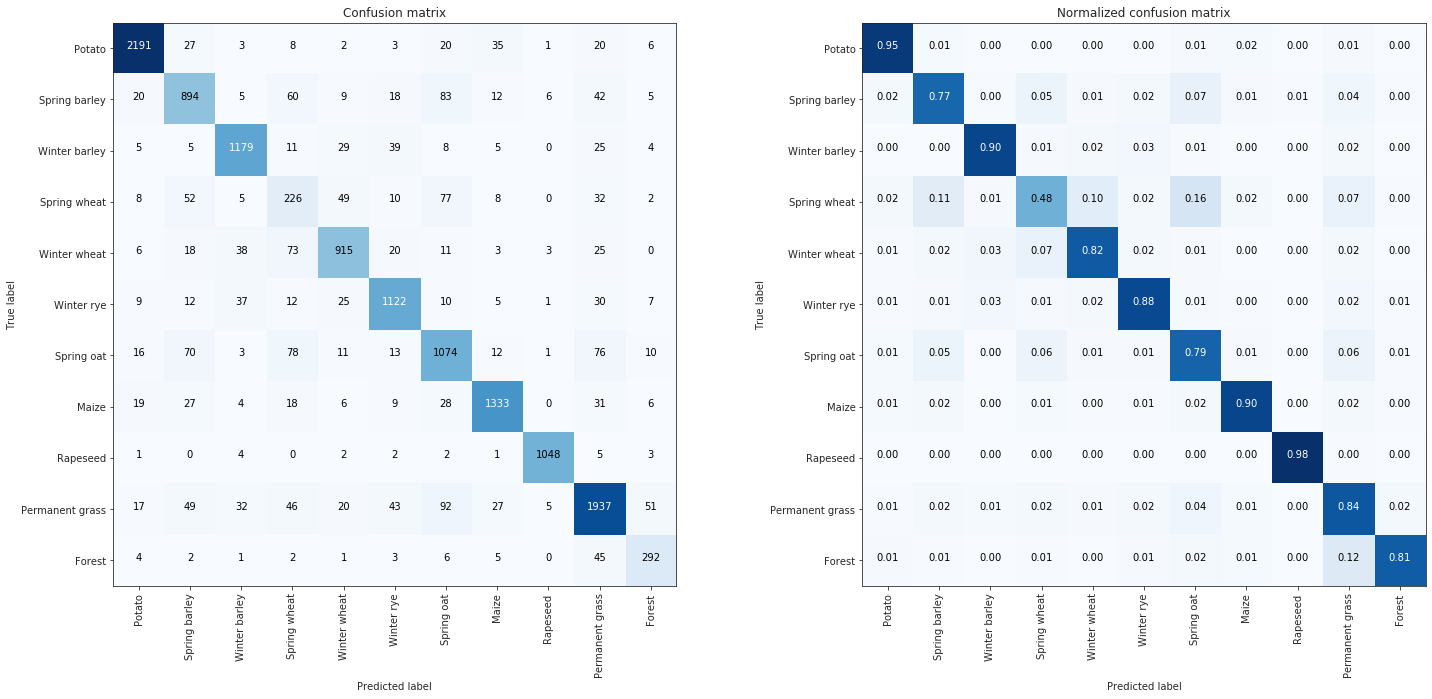

time: 21.3 s


In [27]:
from sklearn.tree import DecisionTreeClassifier              

# Instantiate and evaluate classifier
clf = DecisionTreeClassifier()
clf_trained, _, _, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=False)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training time: 74.1337 s
Prediction time: 0.0112 s

Report:

Train accuracy: 0.934
Test accuracy: 0.9281

                  precision    recall  f1-score   support

         Potato       0.98      0.97      0.97      2316
  Spring barley       0.85      0.89      0.87      1154
  Winter barley       0.97      0.97      0.97      1310
   Spring wheat       0.75      0.41      0.53       469
   Winter wheat       0.93      0.96      0.94      1112
     Winter rye       0.94      0.95      0.95      1270
     Spring oat       0.86      0.87      0.86      1364
          Maize       0.96      0.97      0.97      1481
       Rapeseed       0.99      0.99      0.99      1068
Permanent grass       0.90      0.95      0.93      2319
         Forest       0.89      0.84      0.87       361

       accuracy                           0.93     14224
      macro avg       0.91      0.89      0.90     14224
   weighted avg       0.93      0.93      0.93     14224



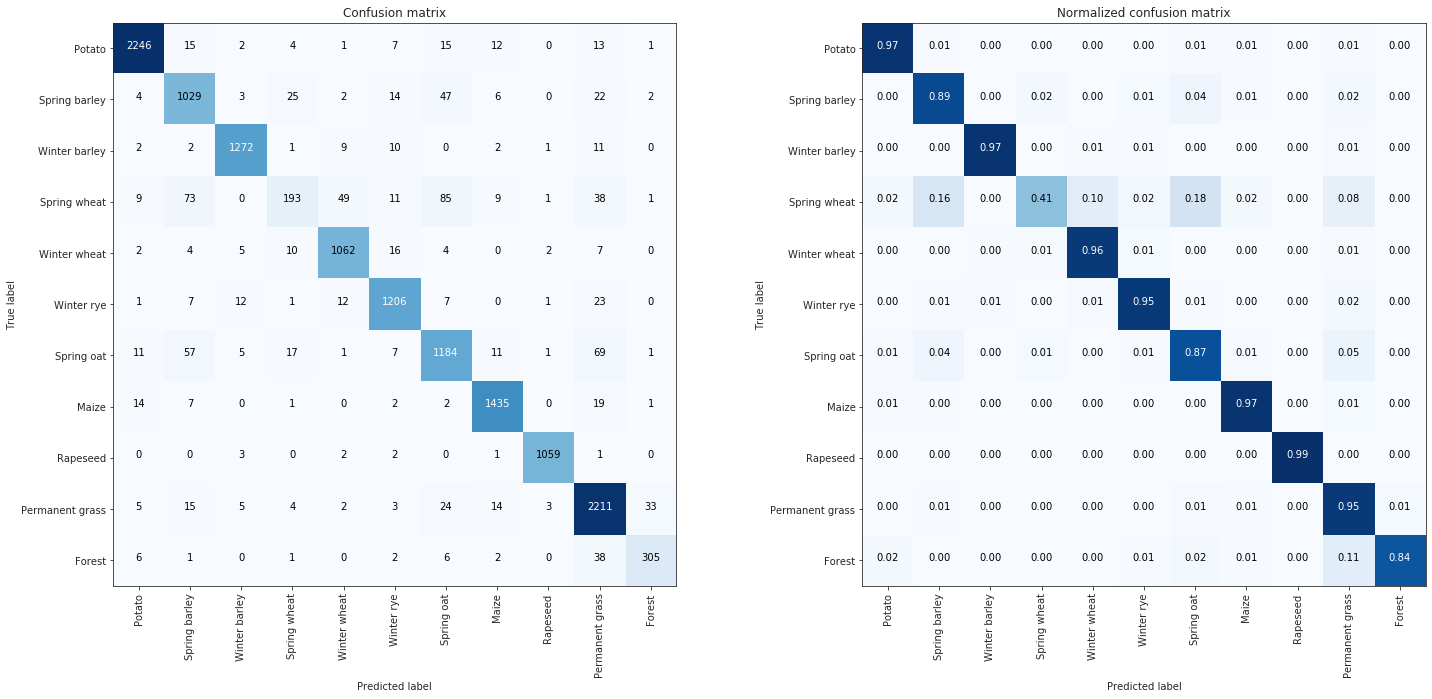

time: 1min 15s


In [28]:
from sklearn.linear_model import LogisticRegression          

# Instantiate classifier.
#clf = LogisticRegression(solver='newton-cg', max_iter=1000)
clf = LogisticRegression()

# Evaluate classifier without feature scaling
clf_trained, _, _, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

Training time: 50.4816 s
Prediction time: 0.014 s

Report:

Train accuracy: 0.9801
Test accuracy: 0.9211

                  precision    recall  f1-score   support

         Potato       0.98      0.97      0.97      2316
  Spring barley       0.85      0.87      0.86      1154
  Winter barley       0.96      0.97      0.96      1310
   Spring wheat       0.62      0.58      0.60       469
   Winter wheat       0.92      0.92      0.92      1112
     Winter rye       0.93      0.93      0.93      1270
     Spring oat       0.85      0.86      0.85      1364
          Maize       0.97      0.96      0.97      1481
       Rapeseed       0.99      0.99      0.99      1068
Permanent grass       0.92      0.93      0.93      2319
         Forest       0.86      0.83      0.84       361

       accuracy                           0.92     14224
      macro avg       0.89      0.89      0.89     14224
   weighted avg       0.92      0.92      0.92     14224



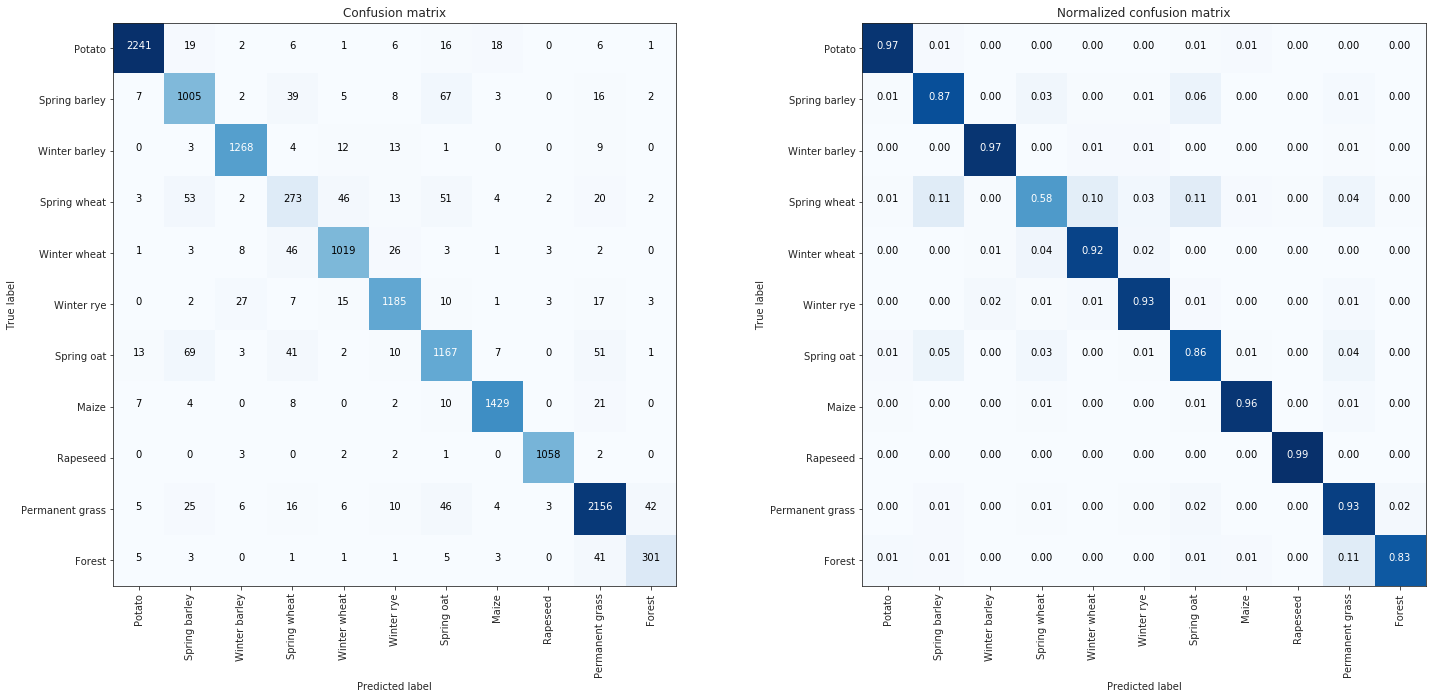

time: 51.8 s


In [31]:
from sklearn.neural_network import MLPClassifier

# Instantiate and evaluate classifier
clf = MLPClassifier(solver='lbfgs', alpha=10, hidden_layer_sizes=(25, 25), max_iter=1000)  # See what happens when you change random state
clf_trained, _, _, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

Training time: 82.9838 s
Prediction time: 18.5798 s

Report:

Train accuracy: 0.9537
Test accuracy: 0.9289

                  precision    recall  f1-score   support

         Potato       0.98      0.97      0.97      2316
  Spring barley       0.86      0.90      0.88      1154
  Winter barley       0.96      0.97      0.96      1310
   Spring wheat       0.68      0.60      0.64       469
   Winter wheat       0.92      0.94      0.93      1112
     Winter rye       0.94      0.94      0.94      1270
     Spring oat       0.88      0.87      0.87      1364
          Maize       0.97      0.96      0.96      1481
       Rapeseed       0.99      0.99      0.99      1068
Permanent grass       0.92      0.94      0.93      2319
         Forest       0.90      0.83      0.86       361

       accuracy                           0.93     14224
      macro avg       0.91      0.90      0.90     14224
   weighted avg       0.93      0.93      0.93     14224



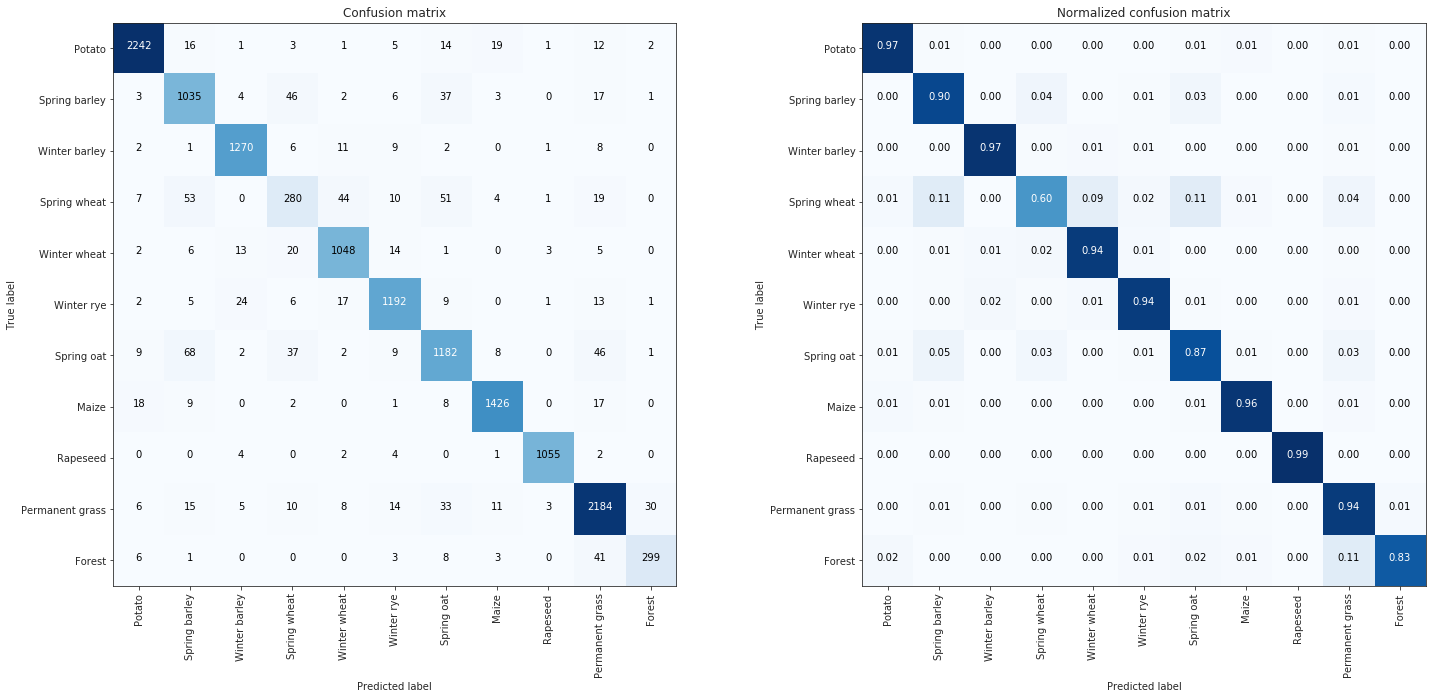

time: 2min 44s


In [30]:
from sklearn.svm import SVC   

# Instantiate and evaluate classifier
clf = SVC(kernel='linear')
clf_trained, _, _, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

Training time: 60.9782 s
Prediction time: 32.6857 s

Report:

Train accuracy: 0.9636
Test accuracy: 0.9476

                  precision    recall  f1-score   support

         Potato       0.98      0.98      0.98      2316
  Spring barley       0.89      0.91      0.90      1154
  Winter barley       0.99      0.98      0.98      1310
   Spring wheat       0.81      0.64      0.72       469
   Winter wheat       0.94      0.97      0.95      1112
     Winter rye       0.96      0.97      0.96      1270
     Spring oat       0.90      0.90      0.90      1364
          Maize       0.98      0.98      0.98      1481
       Rapeseed       1.00      0.99      0.99      1068
Permanent grass       0.93      0.97      0.95      2319
         Forest       0.93      0.84      0.88       361

       accuracy                           0.95     14224
      macro avg       0.94      0.92      0.93     14224
   weighted avg       0.95      0.95      0.95     14224



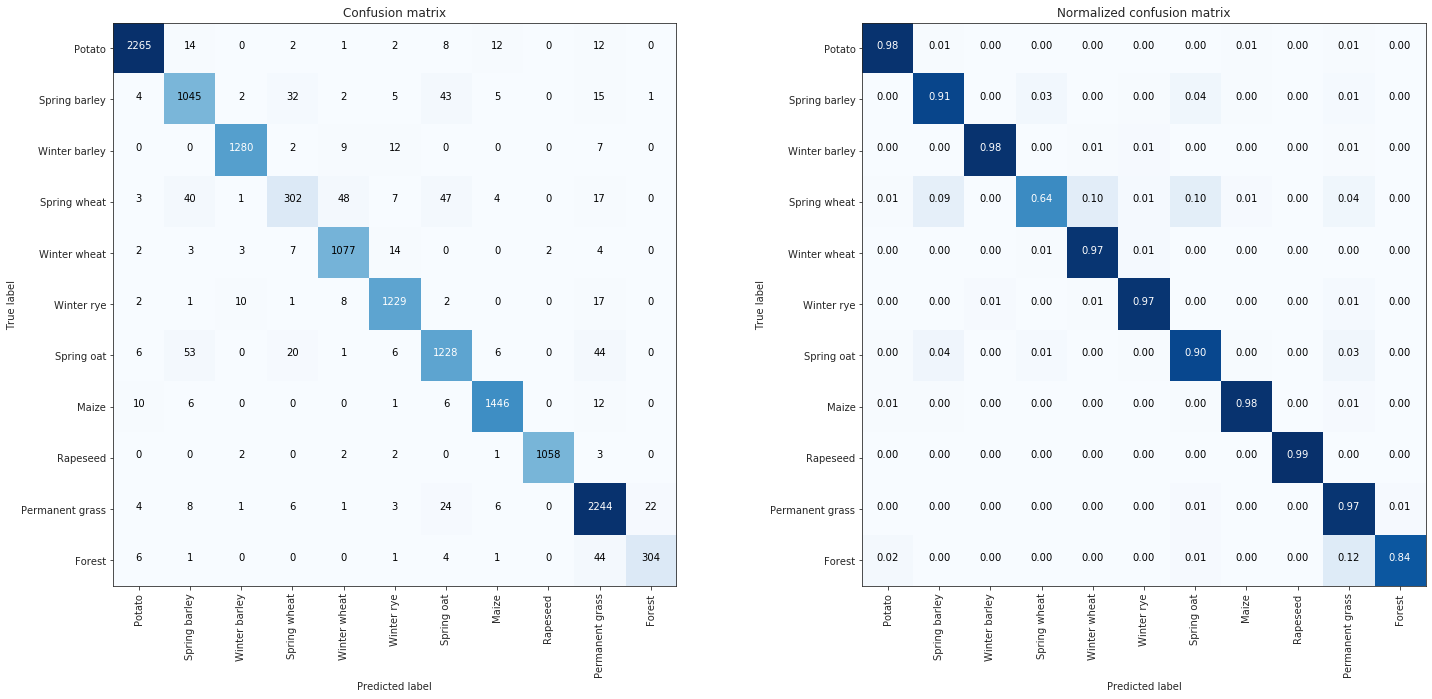

time: 3min 23s


In [29]:
# Instantiate and evaluate classifier
clf = SVC(kernel='rbf')
clf_trained, _, _, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

In [16]:
try:  # If auto-sklearn is installed 
    import autosklearn.classification
except:  # Else install auto-sklearn (https://automl.github.io/auto-sklearn/master/installation.html and https://hub.docker.com/r/alfranz/automl/dockerfile) 
    !sudo apt-get update && sudo apt-get install -y swig curl
    !curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install --default-timeout=100
    !pip install auto-sklearn

time: 96.7 ms


/opt/conda/lib/python3.7/site-packages/pyparsing.py:3174: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


[WARNING] [2020-04-24 17:56:29,245:EnsembleBuilder(1791095845):bdfffda820396a2a3ad53d2c49da093d] No models better than random - using Dummy Score!
[WARNING] [2020-04-24 17:56:29,260:EnsembleBuilder(1791095845):bdfffda820396a2a3ad53d2c49da093d] No models better than random - using Dummy Score!
[WARNING] [2020-04-24 17:56:31,295:EnsembleBuilder(1791095845):bdfffda820396a2a3ad53d2c49da093d] No models better than random - using Dummy Score!
[WARNING] [2020-04-24 17:56:33,304:EnsembleBuilder(1791095845):bdfffda820396a2a3ad53d2c49da093d] No models better than random - using Dummy Score!
[WARNING] [2020-04-24 17:56:35,311:EnsembleBuilder(1791095845):bdfffda820396a2a3ad53d2c49da093d] No models better than random - using Dummy Score!
[WARNING] [2020-04-24 17:56:37,317:EnsembleBuilder(1791095845):bdfffda820396a2a3ad53d2c49da093d] No models better than random - using Dummy Score!
[WARNING] [2020-04-24 17:56:39,322:EnsembleBuilder(1791095845):bdfffda820396a2a3ad53d2c49da093d] No models better than

Process Process-6:
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/automl.py", line 489, in _fit
    _proc_smac.run_smbo()
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/smbo.py", line 513, in run_smbo
    logger=smac.solver.logger,
  File "/opt/conda/lib/python3.7/site-packages/smac/op

Training time: 10132.5376 s
Prediction time: 104.6942 s

Report:

Train accuracy: 0.9889
Test accuracy: 0.9071

                  precision    recall  f1-score   support

         Potato       0.99      0.98      0.98      2316
  Spring barley       0.90      0.92      0.91      1154
  Winter barley       0.98      0.98      0.98      1310
   Spring wheat       0.84      0.68      0.75       469
   Winter wheat       0.93      0.97      0.95      1112
     Winter rye       0.95      0.96      0.96      1270
     Spring oat       0.90      0.90      0.90      1364
          Maize       0.97      0.98      0.97      1481
       Rapeseed       1.00      0.99      0.99      1068
Permanent grass       0.66      0.77      0.71      1152
   Grass silage       0.72      0.62      0.67      1167
         Forest       0.89      0.85      0.87       361

       accuracy                           0.91     14224
      macro avg       0.89      0.88      0.89     14224
   weighted avg       0.91    

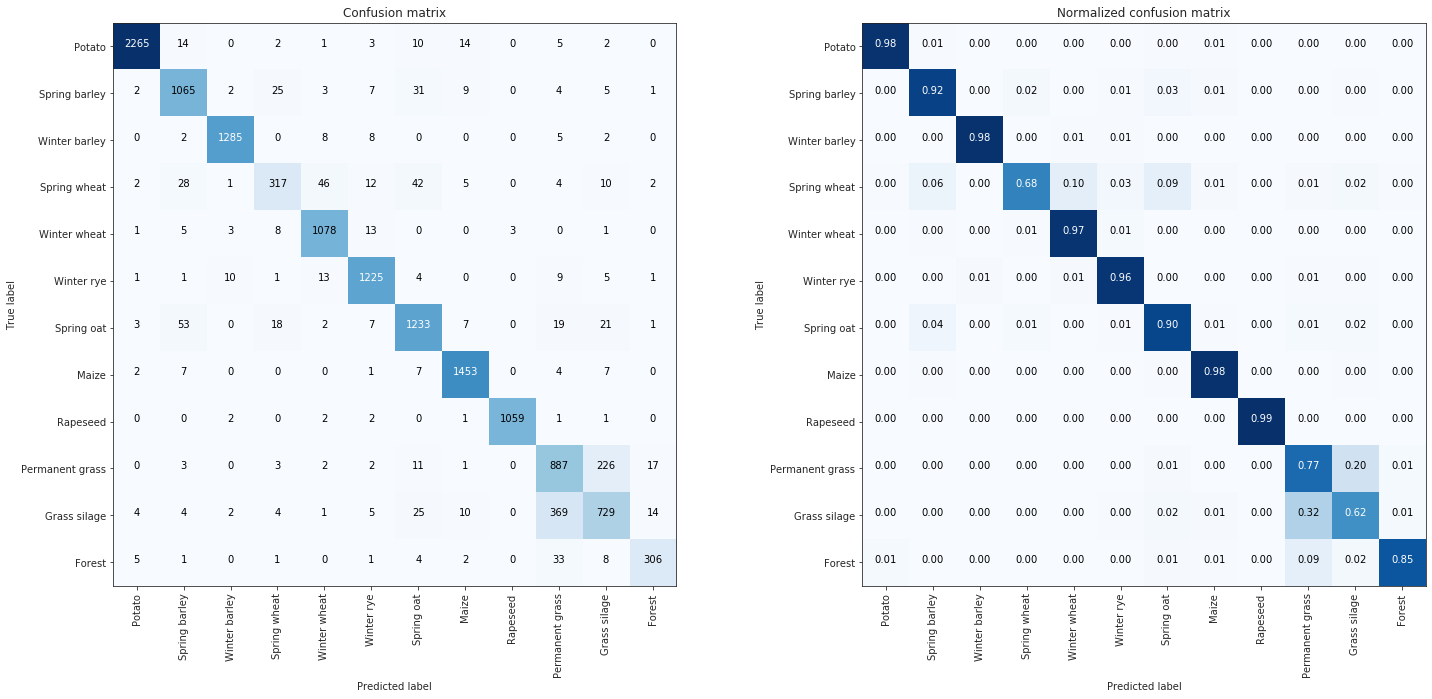

time: 2h 56min 31s


In [17]:
import autosklearn.classification

# Instantiate and evaluate classifier
clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=7200, per_run_time_limit=720, 
                                                       ml_memory_limit=32768, n_jobs=12,  resampling_strategy='cv',
                                                       resampling_strategy_arguments={'folds': 5},)
#clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=3600, per_run_time_limit=360, 
#                                                       ml_memory_limit=32768, n_jobs=24)
clf_trained, _, _, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True, auto_sklearn_crossvalidation=True)

# Then train the ensemble on the whole training dataset
# https://automl.github.io/auto-sklearn/master/examples/example_crossvalidation.html#sphx-glr-examples-example-crossvalidation-py

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:  2.0min
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:  3.7min
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:  3.7min
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:  3.7min
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  3.7min
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:  3.8min
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:  3.8min
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:  4.2min
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:  4.2min
[Parallel(n_jobs=16)]: Done  14 tasks      | elapsed:  4.2min
[Parallel(n_jobs=16)]: Done  15 tasks      | elapsed:  

Training time: 2355.0219 s
Prediction time: 25.3201 s

Report:

Train accuracy: 0.9647
Test accuracy: 0.9461

                  precision    recall  f1-score   support

         Potato       0.99      0.98      0.98      2316
  Spring barley       0.88      0.91      0.90      1154
  Winter barley       0.98      0.98      0.98      1310
   Spring wheat       0.78      0.66      0.71       469
   Winter wheat       0.94      0.97      0.95      1112
     Winter rye       0.95      0.96      0.96      1270
     Spring oat       0.90      0.89      0.90      1364
          Maize       0.98      0.98      0.98      1481
       Rapeseed       1.00      0.99      0.99      1068
Permanent grass       0.93      0.96      0.95      2319
         Forest       0.92      0.85      0.88       361

       accuracy                           0.95     14224
      macro avg       0.93      0.92      0.93     14224
   weighted avg       0.95      0.95      0.95     14224

The best parameters are {'C': 1

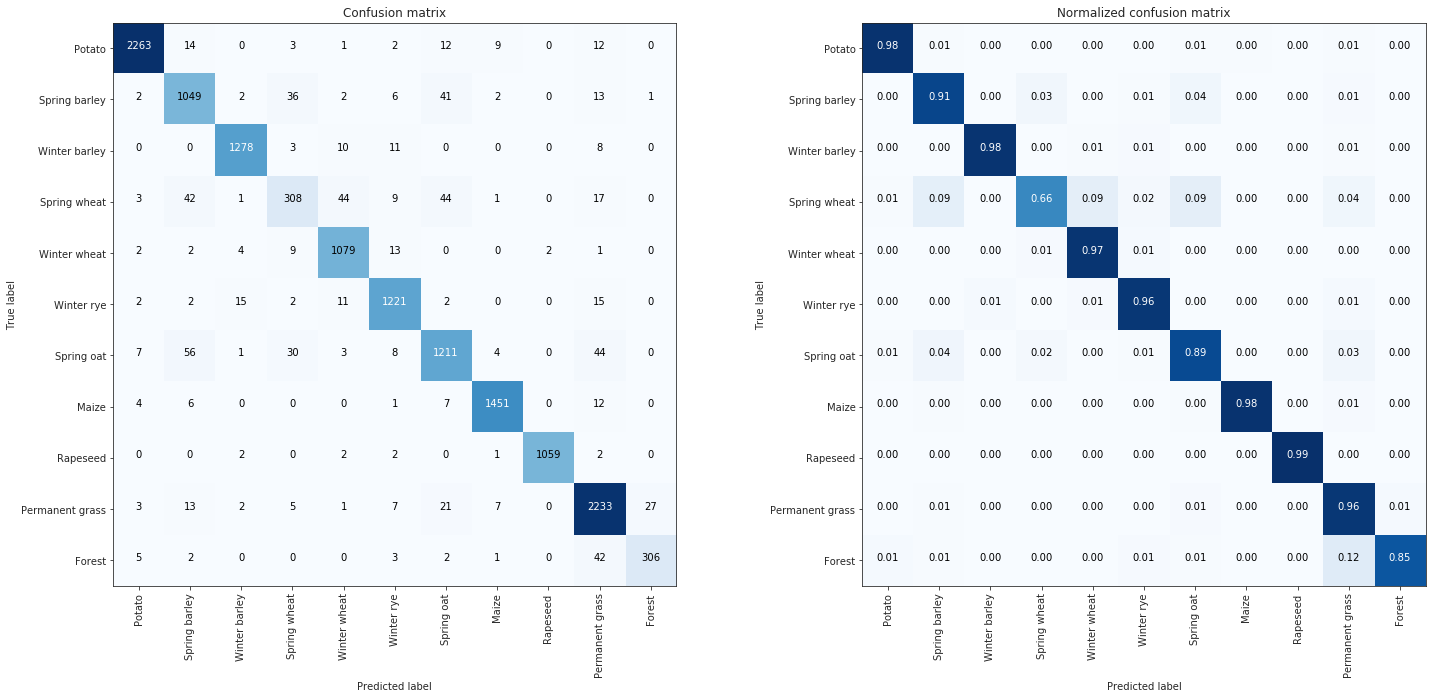

time: 41min 5s


In [32]:
# Take a look at https://towardsdatascience.com/svm-hyper-parameter-tuning-using-gridsearchcv-49c0bc55ce29
from sklearn.svm import SVC   
from sklearn.model_selection import GridSearchCV
#param_grid = {'C': [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7], 
#              'gamma': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 
#              'kernel': ['rbf']}
param_grid = {'C': [1, 1e1, 1e2, 1e3], 
              'gamma': [1e-4, 1e-3, 1e-2, 1e-1], 
              'kernel': ['rbf']}
#grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True, cv=5, verbose=20, n_jobs=32)
grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=20, n_jobs=16)
grid_trained, _, _, _ = evaluate_classifier(grid, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

print(f"The best parameters are {grid_trained.best_params_} with a score of {grid_trained.best_score_:2f}")

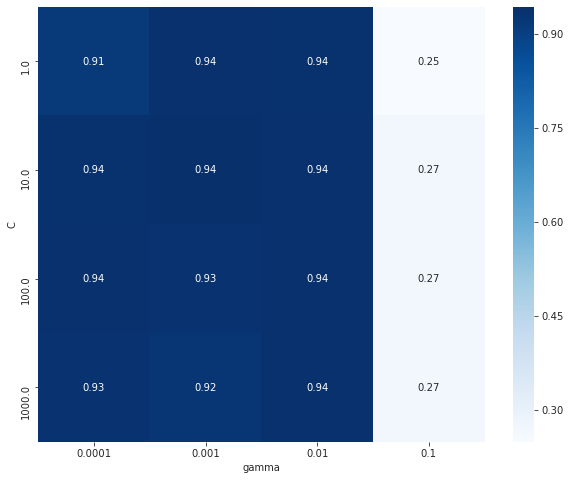

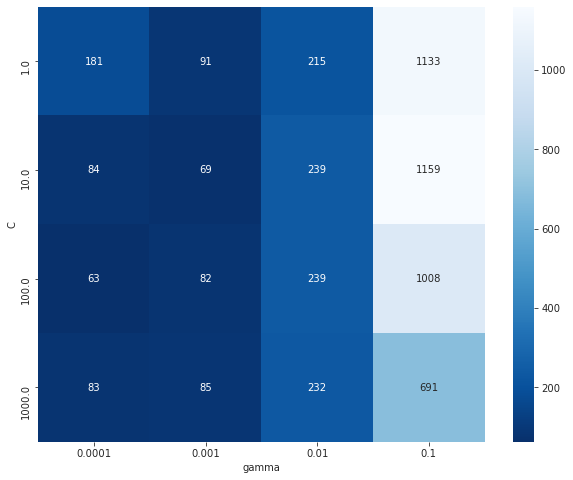

time: 426 ms


In [33]:
# Idea: Maybe make a utils folder, with a plotting module, evaluation module etc.. The below here should 
#       then be put in the plotting module. 
mean_test_scores = grid_trained.cv_results_['mean_test_score']
mean_fit_times = grid_trained.cv_results_['mean_fit_time']
param_columns = list(grid_trained.cv_results_['params'][0].keys())
result_columns = ['mean_fit_time', 'mean_test_score']
num_fits = len(grid_trained.cv_results_['params'])

df_cv_results = pd.DataFrame(0, index=range(num_fits), columns=param_columns+result_columns)
for i, param_set in enumerate(grid_trained.cv_results_['params']):
    for param, value in param_set.items():
        df_cv_results.loc[i, param] = value 
    df_cv_results.loc[i, 'mean_test_score'] = mean_test_scores[i]
    df_cv_results.loc[i, 'mean_fit_time'] = mean_fit_times[i]
    
df_heatmap_mean_score = df_cv_results.pivot(index='C', columns='gamma', values='mean_test_score')
plt.figure(figsize=(10,8))
ax = sns.heatmap(df_heatmap_mean_score, annot=True, cmap=plt.cm.Blues)

df_heatmap_fit_time = df_cv_results.pivot(index='C', columns='gamma', values='mean_fit_time')
plt.figure(figsize=(10,8))
ax = sns.heatmap(df_heatmap_fit_time.astype('int64'), annot=True, fmt='d', cmap=plt.cm.Blues_r)